In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import random
import string
import re
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional, Set
import json
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [8]:
@dataclass
class GameState:
    """Represents the state of a Hangman game"""
    masked_word: str  # Current state with underscores for unknown letters
    guessed_letters: Set[str]  # Letters already guessed
    wrong_guesses: int  # Number of incorrect guesses
    max_wrong_guesses: int = 6  # Standard hangman limit

    def is_game_over(self) -> bool:
        """Check if the game is over (win or loss)"""
        return '_' not in self.masked_word or self.wrong_guesses >= self.max_wrong_guesses

    def is_won(self) -> bool:
        """Check if the game was won"""
        return '_' not in self.masked_word

    def is_lost(self) -> bool:
        """Check if the game was lost"""
        return self.wrong_guesses >= self.max_wrong_guesses

In [9]:
class CorpusAnalyzer:
    """Analyzes the word corpus for HMM training"""

    def __init__(self, corpus_file: str):
        self.corpus_file = corpus_file
        self.words = []
        self.word_lengths = []
        self.letter_frequencies = Counter()
        self.bigram_frequencies = defaultdict(Counter)
        self.positional_frequencies = defaultdict(Counter)

    def load_corpus(self):
        """Load and preprocess the word corpus"""
        with open(self.corpus_file, 'r') as f:
            self.words = [word.strip().lower() for word in f.read().splitlines() if word.strip()]

        # Filter out words with non-alphabetic characters
        self.words = [word for word in self.words if re.match(r'^[a-z]+$', word)]
        self.word_lengths = [len(word) for word in self.words]

        print(f"Loaded {len(self.words)} valid words from {self.corpus_file}")
        print(f"Word length range: {min(self.word_lengths)} - {max(self.word_lengths)}")

    def analyze_patterns(self):
        """Analyze letter patterns in the corpus"""
        for word in self.words:
            # Letter frequency
            self.letter_frequencies.update(word)

            # Positional frequency
            for pos, letter in enumerate(word):
                self.positional_frequencies[pos][letter] += 1

            # Bigram frequency
            for i in range(len(word) - 1):
                bigram = word[i:i+2]
                self.bigram_frequencies[bigram[0]][bigram[1]] += 1

    def get_letter_probability(self, letter: str, position: int = None) -> float:
        """Get probability of a letter (optionally at specific position)"""
        if position is not None:
            total_at_pos = sum(self.positional_frequencies[position].values())
            if total_at_pos == 0:
                return self.letter_frequencies[letter] / sum(self.letter_frequencies.values())
            return self.positional_frequencies[position][letter] / total_at_pos
        return self.letter_frequencies[letter] / sum(self.letter_frequencies.values())

    def plot_analysis(self):
        """Plot corpus analysis results"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Word length distribution
        axes[0,0].hist(self.word_lengths, bins=range(1, max(self.word_lengths)+2), alpha=0.7, edgecolor='black')
        axes[0,0].set_title('Word Length Distribution')
        axes[0,0].set_xlabel('Word Length')
        axes[0,0].set_ylabel('Frequency')

        # Letter frequency
        letters, counts = zip(*sorted(self.letter_frequencies.items()))
        axes[0,1].bar(letters, counts, alpha=0.7)
        axes[0,1].set_title('Letter Frequency in Corpus')
        axes[0,1].set_xlabel('Letters')
        axes[0,1].set_ylabel('Frequency')

        # Top bigrams
        all_bigrams = []
        for first_letter, second_counts in self.bigram_frequencies.items():
            for second_letter, count in second_counts.items():
                all_bigrams.append((first_letter + second_letter, count))

        top_bigrams = sorted(all_bigrams, key=lambda x: x[1], reverse=True)[:20]
        if top_bigrams:
            bigram_labels, bigram_counts = zip(*top_bigrams)
            axes[1,0].barh(bigram_labels, bigram_counts, alpha=0.7)
            axes[1,0].set_title('Top 20 Bigrams')
            axes[1,0].set_xlabel('Frequency')

        # Positional frequency heatmap for common letters
        common_letters = [letter for letter, _ in self.letter_frequencies.most_common(10)]
        max_len = max(self.word_lengths)
        heatmap_data = []
        for letter in common_letters:
            row = []
            for pos in range(max_len):
                total_at_pos = sum(self.positional_frequencies[pos].values())
                if total_at_pos > 0:
                    prob = self.positional_frequencies[pos][letter] / total_at_pos
                else:
                    prob = 0
                row.append(prob)
            heatmap_data.append(row)

        if heatmap_data:
            heatmap_data = np.array(heatmap_data)
            im = axes[1,1].imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
            axes[1,1].set_title('Positional Letter Frequencies')
            axes[1,1].set_xlabel('Position in Word')
            axes[1,1].set_ylabel('Letters')
            axes[1,1].set_xticks(range(min(15, max_len)))
            axes[1,1].set_xticklabels(range(min(15, max_len)))
            axes[1,1].set_yticks(range(len(common_letters)))
            axes[1,1].set_yticklabels(common_letters)
            plt.colorbar(im, ax=axes[1,1])

        plt.tight_layout()
        plt.savefig('corpus_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

In [10]:
class HMMTrainer:
    """Trains Hidden Markov Models for different word lengths"""

    def __init__(self, corpus_analyzer: CorpusAnalyzer):
        self.corpus_analyzer = corpus_analyzer
        self.models = {}  # Store HMM models by word length
        self.vocab_size = 26  # a-z
        self.hidden_states = 5  # Number of hidden states

    def create_training_sequences(self, word_length: int) -> List[List[int]]:
        """Create training sequences for a specific word length"""
        # Filter words of the desired length
        target_words = [word for word in self.corpus_analyzer.words if len(word) == word_length]

        # Convert letters to indices (a=0, b=1, etc.)
        sequences = []
        for word in target_words:
            sequence = [ord(letter) - ord('a') for letter in word]
            sequences.append(sequence)

        return sequences

    def train_hmm_for_length(self, word_length: int, epochs: int = 50) -> Dict:
        """Train HMM for a specific word length using simplified approach"""
        sequences = self.create_training_sequences(word_length)
        if not sequences:
            return None

        print(f"Training HMM for word length {word_length} with {len(sequences)} sequences")

        # Use simple frequency-based approach for emission probabilities
        # Count letter frequencies at each position
        position_counts = defaultdict(Counter)
        total_at_position = defaultdict(int)

        for sequence in sequences:
            for pos, letter_idx in enumerate(sequence):
                letter = chr(ord('a') + letter_idx)
                position_counts[pos][letter] += 1
                total_at_position[pos] += 1

        # Create emission matrix based on positional frequencies
        emission_matrix = np.zeros((self.hidden_states, self.vocab_size))

        # Distribute probabilities across hidden states based on position patterns
        for pos in range(word_length):
            if pos in total_at_position:
                total = total_at_position[pos]
                for letter_idx in range(self.vocab_size):
                    letter = chr(ord('a') + letter_idx)
                    freq = position_counts[pos][letter] / total if total > 0 else 0

                    # Distribute this frequency across hidden states
                    # Simple heuristic: spread across states
                    for state in range(self.hidden_states):
                        base_prob = freq / self.hidden_states
                        # Add some variation between states
                        variation = np.random.normal(0, 0.1 * freq)
                        emission_matrix[state, letter_idx] += max(0, base_prob + variation)

        # Normalize emission matrix
        for state in range(self.hidden_states):
            total = emission_matrix[state].sum()
            if total > 0:
                emission_matrix[state] /= total

        # Simple transition matrix (equal probabilities)
        transition_matrix = np.ones((self.hidden_states, self.hidden_states)) / self.hidden_states

        # Initial probabilities (uniform)
        initial_probs = np.ones(self.hidden_states) / self.hidden_states

        # Store the trained model
        model = {
            'transition_matrix': torch.FloatTensor(transition_matrix),
            'emission_matrix': torch.FloatTensor(emission_matrix),
            'initial_probs': torch.FloatTensor(initial_probs),
            'word_length': word_length
        }

        self.models[word_length] = model
        return model

    def get_letter_probabilities(self, word_length: int, known_positions: Dict[int, str] = None) -> np.ndarray:
        """Get letter probabilities for a word of given length"""
        if word_length not in self.models:
            # Fall back to corpus frequencies if no model trained
            total_letters = sum(self.corpus_analyzer.letter_frequencies.values())
            probs = np.array([self.corpus_analyzer.letter_frequencies[chr(ord('a') + i)] / total_letters
                             for i in range(26)])
            return probs

        model = self.models[word_length]
        emission = model['emission_matrix']

        # Average emission probabilities across hidden states
        letter_probs = emission.mean(dim=0).numpy()

        # Normalize
        probs = letter_probs / letter_probs.sum()

        # Apply known letter constraints
        if known_positions:
            for pos, letter in known_positions.items():
                letter_idx = ord(letter.lower()) - ord('a')
                # Boost probability for known letters at correct positions
                if 0 <= pos < word_length:
                    # Reduce other letters, increase this one
                    probs[letter_idx] = max(probs[letter_idx], 0.3)
                    other_sum = 1.0 - probs[letter_idx]
                    probs[:letter_idx] *= other_sum / (1.0 - probs[letter_idx] + 1e-10)
                    probs[letter_idx+1:] *= other_sum / (1.0 - probs[letter_idx] + 1e-10)


        return probs

    def train_all_models(self, max_length: int = 15, epochs: int = 50):
        """Train HMM models for all word lengths up to max_length"""
        print("Training HMM models for different word lengths...")

        for length in range(1, max_length + 1):
            sequences = self.create_training_sequences(length)
            if len(sequences) > 5:  # Only train if enough data
                self.train_hmm_for_length(length, epochs)
            else:
                print(f"Skipping length {length}: insufficient data ({len(sequences)} sequences)")

In [11]:
class RLEnvironment:
    """Environment for RL agent to play Hangman"""

    def __init__(self, corpus_analyzer: CorpusAnalyzer, hmm_trainer: HMMTrainer):
        self.corpus_analyzer = corpus_analyzer
        self.hmm_trainer = hmm_trainer
        self.words_by_length = defaultdict(list)

        # Group words by length for efficient selection
        for word in corpus_analyzer.words:
            self.words_by_length[len(word)].append(word)

    def reset(self, word: str = None) -> GameState:
        """Reset environment with a new word"""
        if word is None:
            # Select a random word with bias towards common lengths
            lengths = list(self.words_by_length.keys())
            # Weight selection towards more common word lengths (4-8 letters)
            weights = []
            for length in lengths:
                if 4 <= length <= 8:
                    weights.append(3.0)  # Higher weight for common lengths
                elif 3 <= length <= 10:
                    weights.append(1.5)  # Medium weight for reasonable lengths
                else:
                    weights.append(0.5)  # Lower weight for very short/long words

            chosen_length = random.choices(lengths, weights=weights, k=1)[0]
            word = random.choice(self.words_by_length[chosen_length])

        self.target_word = word
        self.state = GameState(
            masked_word='_' * len(word),
            guessed_letters=set(),
            wrong_guesses=0
        )
        return self.state

    def step(self, action: str) -> Tuple[GameState, float, bool]:
        """Take a step in the environment"""
        letter = action.lower()

        # Check if letter was already guessed
        if letter in self.state.guessed_letters:
            reward = -5.0  # Higher penalty for repeated guess
            return self.state, reward, False

        self.state.guessed_letters.add(letter)

        if letter in self.target_word:
            # Update masked word
            new_masked = ""
            for i, char in enumerate(self.target_word):
                if char == letter:
                    new_masked += char
                else:
                    new_masked += self.state.masked_word[i]
            self.state.masked_word = new_masked

            # Reward based on information gained
            unknown_before = self.state.masked_word.count('_') + 1
            unknown_after = new_masked.count('_')
            info_gain = unknown_before - unknown_after
            reward = 2.0 * info_gain  # Higher reward for more letters revealed

            # Bonus for completing the word
            if unknown_after == 0:
                reward += 10.0  # Big bonus for winning

        else:
            self.state.wrong_guesses += 1
            # Progressive penalty for wrong guesses
            penalty_multiplier = 1 + (self.state.wrong_guesses * 0.3)
            reward = -1.5 * penalty_multiplier

        # Check if game is over
        done = self.state.is_game_over()

        # Additional rewards/penalties for game end
        if done:
            if self.state.is_won():
                # Big bonus for winning with few wrong guesses
                bonus = max(0, 15 - (self.state.wrong_guesses * 2))
                reward += bonus
            else:
                # Penalty for losing
                reward -= 8.0

        return self.state, reward, done

    def get_state_features(self, state: GameState) -> np.ndarray:
        """Extract features from game state for RL agent"""
        word_length = len(state.masked_word)

        # HMM-based letter probabilities
        known_positions = {}
        for i, char in enumerate(state.masked_word):
            if char != '_':
                known_positions[i] = char

        hmm_probs = self.hmm_trainer.get_letter_probabilities(word_length, known_positions)

        # Corpus-based letter frequencies
        total_letters = sum(self.corpus_analyzer.letter_frequencies.values())
        corpus_probs = np.array([self.corpus_analyzer.letter_frequencies[chr(ord('a') + i)] / total_letters
                               for i in range(26)])

        # Game state features
        remaining_guesses = max(0, state.max_wrong_guesses - state.wrong_guesses)
        progress = (word_length - state.masked_word.count('_')) / word_length

        # One-hot encode guessed letters
        guessed_vector = np.zeros(26)
        for letter in state.guessed_letters:
            if letter.isalpha():
                idx = ord(letter) - ord('a')
                guessed_vector[idx] = 1

        # Combine features
        features = np.concatenate([
            hmm_probs * 0.6 + corpus_probs * 0.4,  # Weighted letter probabilities
            guessed_vector * 0.3,  # Penalize already guessed letters
            [remaining_guesses / state.max_wrong_guesses, progress]  # Game progress
        ])

        return features

In [12]:
class QNetwork(nn.Module):
    """Deep Q-Network for the RL agent"""

    def __init__(self, state_size: int, action_size: int = 26, hidden_size: int = 128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

In [13]:
class RLAgent:
    """Reinforcement Learning agent for Hangman with hybrid strategy"""

    def __init__(self, env: RLEnvironment, lr: float = 0.001, gamma: float = 0.99,
                 epsilon: float = 0.3, epsilon_min: float = 0.01, epsilon_decay: float = 0.995):
        self.env = env
        self.state_size = 26 + 26 + 2  # Letter probs + guessed letters + game state
        self.action_size = 26  # 26 letters
        self.memory = []
        self.memory_capacity = 5000  # Reduced memory for faster training

        self.qnetwork = QNetwork(self.state_size, self.action_size)
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def get_action(self, state: GameState, available_letters: Set[str] = None) -> str:
        """Select action using hybrid HMM + RL strategy"""
        if available_letters is None:
            available_letters = set(string.ascii_lowercase)

        # Remove already guessed letters
        available_letters = available_letters - state.guessed_letters
        if not available_letters:
            return random.choice(string.ascii_lowercase)

        # Use HMM-based strategy with some RL guidance
        word_length = len(state.masked_word)
        known_positions = {}
        for i, char in enumerate(state.masked_word):
            if char != '_':
                known_positions[i] = char

        # Get HMM probabilities
        hmm_probs = self.env.hmm_trainer.get_letter_probabilities(word_length, known_positions)

        # Get corpus frequencies
        total_letters = sum(self.env.corpus_analyzer.letter_frequencies.values())
        corpus_probs = np.array([self.env.corpus_analyzer.letter_frequencies[chr(ord('a') + i)] / total_letters
                               for i in range(26)])

        # Combine probabilities with strong HMM bias
        combined_probs = hmm_probs * 0.7 + corpus_probs * 0.3

        # Apply penalties for already guessed letters
        for letter in state.guessed_letters:
            if letter.isalpha():
                idx = ord(letter) - ord('a')
                combined_probs[idx] = 0

        # Apply availability filter
        for letter in set(string.ascii_lowercase) - available_letters:
            idx = ord(letter) - ord('a')
            combined_probs[idx] = 0

        # Epsilon-greedy with HMM-based exploration
        if random.random() <= self.epsilon:
            # Use probability-weighted random selection
            total_prob = combined_probs.sum()
            if total_prob > 0:
                combined_probs = combined_probs / total_prob
                # Convert to available letters with probabilities
                letter_list = []
                prob_list = []
                for i, prob in enumerate(combined_probs):
                    if prob > 0:
                        letter_list.append(string.ascii_lowercase[i])
                        prob_list.append(prob)
                if letter_list:
                    return random.choices(letter_list, weights=prob_list, k=1)[0]

        # Best action selection
        if combined_probs.sum() > 0:
            best_idx = np.argmax(combined_probs)
            return string.ascii_lowercase[best_idx]

        # Fallback to random if all else fails
        return random.choice(list(available_letters))

    def train(self, batch_size: int = 32):
        """Train the agent"""
        if len(self.memory) < batch_size:
            return

        # Sample batch from memory
        batch = random.sample(self.memory, batch_size)

        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors
        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(np.array(next_states))
        dones = torch.BoolTensor(dones)

        # Current Q values
        current_q = self.qnetwork(states)
        current_q = current_q.gather(1, actions.unsqueeze(1)).squeeze(1)

        # Next Q values
        with torch.no_grad():
            next_q = self.qnetwork(next_states)
            max_next_q = next_q.max(1)[0]
            target_q = rewards + self.gamma * max_next_q * ~dones

        # Loss
        loss = nn.MSELoss()(current_q, target_q)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def remember(self, state: np.ndarray, action: int, reward: float,
                next_state: np.ndarray, done: bool):
        """Store experience in memory"""
        if len(self.memory) >= self.memory_capacity:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state, done))

    def get_state_vector(self, state: GameState) -> np.ndarray:
        """Convert game state to feature vector"""
        return self.env.get_state_features(state)

In [14]:
class HangmanGame:
    """Main Hangman game controller with advanced AI strategy for 90%+ win rate"""

    def __init__(self, corpus_file: str = 'corpus.txt'):
        self.corpus_analyzer = CorpusAnalyzer(corpus_file)
        self.corpus_analyzer.load_corpus()
        self.corpus_analyzer.analyze_patterns()

        self.hmm_trainer = HMMTrainer(self.corpus_analyzer)
        self.hmm_trainer.train_all_models()

        self.env = RLEnvironment(self.corpus_analyzer, self.hmm_trainer)
        self.agent = RLAgent(self.env)

    def get_possible_words(self, state: GameState) -> List[str]:
        """Get list of possible words matching the current state using advanced filtering"""
        word_length = len(state.masked_word)

        # Use HMM to pre-filter by most likely word patterns
        hmm_probs = self.hmm_trainer.get_letter_probabilities(word_length)

        # Filter by length first
        target_words = [word for word in self.corpus_analyzer.words if len(word) == word_length]

        # Advanced pattern matching with letter probability weighting
        possible_words = []
        for word in target_words:
            match_score = 0.0
            valid_match = True

            for i, char in enumerate(state.masked_word):
                if char != '_' and word[i] != char:
                    valid_match = False
                    break
                elif char == '_':
                    # Add probability score for unknown positions
                    letter_idx = ord(word[i]) - ord('a')
                    match_score += hmm_probs[letter_idx]

            if valid_match:
                # Weight by overall word probability (product of letter probs)
                word_prob = 1.0
                for i, letter in enumerate(word):
                    letter_idx = ord(letter) - ord('a')
                    word_prob *= max(hmm_probs[letter_idx], 0.001)  # Avoid zero probabilities

                possible_words.append((word, match_score * word_prob))

        # Sort by score and return just the words
        possible_words.sort(key=lambda x: x[1], reverse=True)
        return [word for word, score in possible_words]

    def get_best_letter_by_bayesian_optimization(self, state: GameState) -> str:
        """Get the best letter using Bayesian optimization and advanced pattern analysis"""
        possible_words = self.get_possible_words(state)

        if len(possible_words) <= 1:
            if possible_words:
                # If we know the word, guess its remaining letters
                word = possible_words[0]
                for letter in word:
                    if letter not in state.guessed_letters:
                        return letter
            return self.get_best_letter_by_hmm(state)

        available_letters = set(string.ascii_lowercase) - state.guessed_letters
        if not available_letters:
            return random.choice(string.ascii_lowercase)

        # Use Bayesian approach with word frequency weighting
        word_length = len(state.masked_word)
        hmm_probs = self.hmm_trainer.get_letter_probabilities(word_length)

        best_letter = None
        best_expected_success_rate = -1

        for letter in available_letters:
            # Calculate Bayesian posterior probabilities
            with_letter_words = [word for word in possible_words if letter in word]
            without_letter_words = [word for word in possible_words if letter not in word]

            # Weight words by their HMM-based probability
            with_weight = sum(self._get_word_probability(word, hmm_probs) for word in with_letter_words)
            without_weight = sum(self._get_word_probability(word, hmm_probs) for word in without_letter_words)
            total_weight = with_weight + without_weight

            if total_weight == 0:
                continue

            p_with = with_weight / total_weight
            p_without = without_weight / total_weight

            # Calculate expected success rate for each scenario
            expected_success = 0

            # Scenario 1: Letter is correct (with_letter_words)
            if with_letter_words and p_with > 0:
                # For each possible word that contains this letter,
                # calculate the probability of winning from the resulting state
                with_success_rate = 0
                for word in with_letter_words:
                    word_prob = self._get_word_probability(word, hmm_probs) / with_weight
                    # Simulate the resulting state after guessing this letter correctly
                    simulated_state = self._simulate_state_after_guess(state, letter, word)
                    future_success_rate = self._estimate_future_success(simulated_state, with_letter_words)
                    with_success_rate += word_prob * future_success_rate
                expected_success += p_with * with_success_rate

            # Scenario 2: Letter is incorrect (without_letter_words)
            if without_letter_words and p_without > 0:
                # If wrong guess, we eliminate all words containing this letter
                # Calculate success rate with remaining words
                remaining_words = without_letter_words
                if remaining_words:
                    without_success_rate = self._estimate_future_success(state, remaining_words)
                    expected_success += p_without * without_success_rate
                else:
                    expected_success += p_without * 0  # No words left = certain loss

            # Prefer letters that maximize expected success rate
            if expected_success > best_expected_success_rate:
                best_expected_success_rate = expected_success
                best_letter = letter

        return best_letter or self.get_best_letter_by_hmm(state)

    def _get_word_probability(self, word: str, hmm_probs: np.ndarray) -> float:
        """Calculate word probability based on HMM letter probabilities"""
        probability = 1.0
        for letter in word:
            letter_idx = ord(letter) - ord('a')
            probability *= max(hmm_probs[letter_idx], 0.001)  # Avoid zero probabilities
        return probability

    def _simulate_state_after_guess(self, state: GameState, guessed_letter: str, target_word: str) -> GameState:
        """Simulate the game state after guessing a letter correctly"""
        new_masked = ""
        for i, char in enumerate(target_word):
            if char == guessed_letter:
                new_masked += char
            else:
                new_masked += state.masked_word[i]

        return GameState(
            masked_word=new_masked,
            guessed_letters=state.guessed_letters.copy(),
            wrong_guesses=state.wrong_guesses
        )

    def _estimate_future_success(self, state: GameState, possible_words: List[str]) -> float:
        """Estimate the probability of winning from current state with given word candidates"""
        # Simple heuristic: more remaining candidates = lower success probability
        # Fewer remaining unknown positions = higher success probability

        unknown_positions = state.masked_word.count('_')
        remaining_candidates = len(possible_words)
        remaining_guesses = 6 - state.wrong_guesses

        if remaining_candidates == 0:
            return 0.0
        if remaining_candidates == 1:
            # If we know the word, success depends on having enough guesses
            word = possible_words[0]
            unknown_letters = len(set(word) - state.guessed_letters)
            return 1.0 if unknown_letters <= remaining_guesses else 0.5

        # Bayesian estimation based on information theory
        if unknown_positions == 0:
            return 1.0  # Already won

        if remaining_guesses <= 0:
            return 0.0  # Already lost

        # Estimate based on entropy reduction potential
        current_entropy = self._calculate_word_entropy(possible_words)
        if current_entropy == 0:
            return 1.0

        # Approximate: success rate decreases with more candidates and unknown positions
        # but increases with more remaining guesses
        candidate_factor = max(0, 1 - (remaining_candidates / 50))  # Diminishing returns
        guess_factor = remaining_guesses / 6
        unknown_factor = max(0, 1 - (unknown_positions / len(state.masked_word)))

        return min(1.0, (candidate_factor * 0.4 + guess_factor * 0.4 + unknown_factor * 0.2))

    def _calculate_word_entropy(self, words: List[str]) -> float:
        """Calculate entropy of a set of words"""
        if len(words) <= 1:
            return 0

        # Calculate weighted entropy based on word probabilities
        total_weight = 0
        word_weights = []
        hmm_probs = self.hmm_trainer.get_letter_probabilities(len(words[0]) if words else 1)

        for word in words:
            weight = self._get_word_probability(word, hmm_probs)
            word_weights.append(weight)
            total_weight += weight

        if total_weight == 0:
            return 0

        # Calculate entropy with weighted probabilities
        entropy = 0
        for weight in word_weights:
            if weight > 0:
                prob = weight / total_weight
                entropy -= prob * np.log2(prob)

        return entropy

    def get_best_letter_by_entropy(self, state: GameState) -> str:
        """Get the best letter using information theory (minimize entropy)"""
        possible_words = self.get_possible_words(state)

        if len(possible_words) <= 1:
            if possible_words:
                # If we know the word, guess its remaining letters
                word = possible_words[0]
                for letter in word:
                    if letter not in state.guessed_letters:
                        return letter
            return self.get_best_letter_by_hmm(state)

        available_letters = set(string.ascii_lowercase) - state.guessed_letters
        if not available_letters:
            return random.choice(string.ascii_lowercase)

        best_letter = None
        best_information_gain = -1

        for letter in available_letters:
            # Calculate expected information gain (entropy reduction)
            # Split words into groups: those containing the letter vs those that don't
            with_letter = [word for word in possible_words if letter in word]
            without_letter = [word for word in possible_words if letter not in word]

            total_words = len(possible_words)
            p_with = len(with_letter) / total_words
            p_without = len(without_letter) / total_words

            # Entropy before
            entropy_before = 0
            if p_with > 0 and p_without > 0:
                entropy_before = -p_with * np.log2(p_with) - p_without * np.log2(p_without)

            # Expected entropy after guessing this letter
            expected_entropy = 0
            if p_with > 0:
                # If letter is in word, filter to only words containing it
                with_entropy = self._calculate_word_entropy(with_letter)
                expected_entropy += p_with * with_entropy

            if p_without > 0:
                # If letter is not in word, filter to words without it
                without_entropy = self._calculate_word_entropy(without_letter)
                expected_entropy += p_without * without_entropy

            information_gain = entropy_before - expected_entropy

            if information_gain > best_information_gain:
                best_information_gain = information_gain
                best_letter = letter

        return best_letter or self.get_best_letter_by_hmm(state)

    def get_best_letter_by_pattern_matching(self, state: GameState) -> str:
        """Get the best letter using advanced pattern matching"""
        possible_words = self.get_possible_words(state)

        if not possible_words:
            return self.get_best_letter_by_hmm(state)

        # If we have very few candidates, use direct frequency analysis
        if len(possible_words) <= 5:
            letter_counts = Counter()
            for word in possible_words:
                for letter in set(word):  # Count each letter only once per word
                    if letter not in state.guessed_letters:
                        letter_counts[letter] += 1

            if letter_counts:
                return letter_counts.most_common(1)[0][0]

        # For larger candidate sets, use pattern-based approach
        word_length = len(state.masked_word)
        available_letters = set(string.ascii_lowercase) - state.guessed_letters

        best_letter = None
        best_pattern_score = -1

        for letter in available_letters:
            # Calculate how this guess would partition the word space
            with_letter_count = sum(1 for word in possible_words if letter in word)
            without_letter_count = len(possible_words) - with_letter_count

            # Prefer letters that create balanced partitions (maximize information)
            if with_letter_count > 0 and without_letter_count > 0:
                balance_score = min(with_letter_count, without_letter_count) / max(with_letter_count, without_letter_count)

                # Also consider how many words this would eliminate in the worst case
                worst_case_remaining = max(with_letter_count, without_letter_count)
                elimination_score = 1.0 / (worst_case_remaining + 1)

                # Combine scores
                pattern_score = balance_score * 0.6 + elimination_score * 0.4

                if pattern_score > best_pattern_score:
                    best_pattern_score = pattern_score
                    best_letter = letter

        return best_letter or self.get_best_letter_by_hmm(state)

    def _get_optimal_letter_for_known_word(self, state: GameState, word: str, remaining_letters: List[str]) -> str:
        """Get the optimal letter to guess when we know the target word"""
        # When we know the word, we want to minimize wrong guesses
        # So choose the letter that appears most frequently in the corpus
        # at the positions where it appears in our word

        best_letter = None
        best_corpus_score = -1

        for letter in remaining_letters:
            # Find positions where this letter appears in the word
            positions = [i for i, char in enumerate(word) if char == letter]

            # Calculate average corpus frequency at these positions
            pos_scores = []
            for pos in positions:
                freq = self.corpus_analyzer.get_letter_probability(letter, pos)
                pos_scores.append(freq)

            avg_score = np.mean(pos_scores) if pos_scores else 0

            if avg_score > best_corpus_score:
                best_corpus_score = avg_score
                best_letter = letter

        return best_letter or remaining_letters[0]

    def _get_best_letter_by_weighted_entropy(self, state: GameState) -> str:
        """Get the best letter using weighted entropy with Bayesian optimization"""
        possible_words = self.get_possible_words(state)

        if len(possible_words) <= 1:
            if possible_words:
                word = possible_words[0]
                for letter in word:
                    if letter not in state.guessed_letters:
                        return letter
            return self.get_best_letter_by_hmm(state)

        available_letters = set(string.ascii_lowercase) - state.guessed_letters
        if not available_letters:
            return random.choice(string.ascii_lowercase)

        # Use weighted approach combining entropy and Bayesian optimization
        word_length = len(state.masked_word)
        hmm_probs = self.hmm_trainer.get_letter_probabilities(word_length)

        best_letter = None
        best_combined_score = -1

        for letter in available_letters:
            # Calculate entropy-based information gain
            with_letter = [word for word in possible_words if letter in word]
            without_letter = [word for word in possible_words if letter not in word]

            total_words = len(possible_words)
            p_with = len(with_letter) / total_words
            p_without = len(without_letter) / total_words

            # Entropy before
            entropy_before = 0
            if p_with > 0 and p_without > 0:
                entropy_before = -p_with * np.log2(p_with) - p_without * np.log2(p_without)

            # Expected entropy after
            expected_entropy = 0
            if p_with > 0:
                with_entropy = self._calculate_word_entropy(with_letter)
                expected_entropy += p_with * with_entropy

            if p_without > 0:
                without_entropy = self._calculate_word_entropy(without_letter)
                expected_entropy += p_without * without_entropy

            information_gain = entropy_before - expected_entropy

            # Calculate Bayesian expected success rate
            with_weight = sum(self._get_word_probability(word, hmm_probs) for word in with_letter)
            without_weight = sum(self._get_word_probability(word, hmm_probs) for word in without_letter)
            total_weight = with_weight + without_weight

            if total_weight > 0:
                p_with_bayesian = with_weight / total_weight
                p_without_bayesian = without_weight / total_weight

                # Expected success rate
                expected_success = 0
                if with_weight > 0:
                    with_success = sum(self._get_word_probability(word, hmm_probs) / with_weight *
                                     self._estimate_future_success(
                                         self._simulate_state_after_guess(state, letter, word),
                                         with_letter
                                     ) for word in with_letter)
                    expected_success += p_with_bayesian * with_success

                if without_weight > 0:
                    without_success = self._estimate_future_success(state, without_letter)
                    expected_success += p_without_bayesian * without_success
            else:
                expected_success = 0.5  # Default

            # Combine scores with optimal weights
            combined_score = information_gain * 0.6 + expected_success * 0.4

            if combined_score > best_combined_score:
                best_combined_score = combined_score
                best_letter = letter

        return best_letter or self.get_best_letter_by_hmm(state)


    def get_best_letter_by_hmm(self, state: GameState) -> str:
        """Get the best letter based on HMM probabilities"""
        word_length = len(state.masked_word)
        known_positions = {}
        for i, char in enumerate(state.masked_word):
            if char != '_':
                known_positions[i] = char

        hmm_probs = self.hmm_trainer.get_letter_probabilities(word_length, known_positions)
        available_letters = set(string.ascii_lowercase) - state.guessed_letters

        best_letter = None
        best_score = -1
        for letter in available_letters:
            idx = ord(letter) - ord('a')
            score = hmm_probs[idx]
            if score > best_score:
                best_score = score
                best_letter = letter
        return best_letter or random.choice(list(available_letters))


    def play_game(self, word: str = None, verbose: bool = True) -> Dict:
        """Play a single game of Hangman with ultimate AI strategy"""
        state = self.env.reset(word)
        initial_word_length = len(state.masked_word)

        if verbose:
            print(f"\nStarting game with word length: {initial_word_length}")
            print(f"Initial state: {state.masked_word}")

        game_history = []
        game_over = False

        while not game_over:
            # Use ultimate multi-strategy optimization
            remaining_guesses = 6 - state.wrong_guesses
            unknown_positions = state.masked_word.count('_')
            possible_words = self.get_possible_words(state)
            possible_words_count = len(possible_words)

            # Strategy selection based on game state
            if remaining_guesses <= 2 or unknown_positions <= 3:
                # Endgame: Maximum precision with pattern matching
                action = self.get_best_letter_by_pattern_matching(state)
            elif possible_words_count == 1:
                # We know the word: guess its remaining letters optimally
                word = possible_words[0]
                available_letters = set(string.ascii_lowercase) - state.guessed_letters
                remaining_letters = [letter for letter in word if letter in available_letters]
                if remaining_letters:
                    # Guess the letter that appears most frequently in similar positions
                    action = self._get_optimal_letter_for_known_word(state, word, remaining_letters)
                else:
                    action = random.choice(list(set(string.ascii_lowercase) - state.guessed_letters))
            elif possible_words_count <= 5:
                # Very few candidates: Use Bayesian optimization
                action = self.get_best_letter_by_bayesian_optimization(state)
            elif possible_words_count <= 20:
                # Few candidates: Use entropy optimization with Bayesian weighting
                action = self._get_best_letter_by_weighted_entropy(state)
            elif unknown_positions > len(state.masked_word) // 2:
                # Early game: Maximum information gain
                action = self.get_best_letter_by_entropy(state)
            else:
                # Mid game: Balanced pattern matching
                action = self.get_best_letter_by_pattern_matching(state)

            # Take step in environment
            next_state, reward, done = self.env.step(action)

            # Store experience for training (keep RL learning)
            state_vector = self.agent.get_state_vector(state)
            next_state_vector = self.agent.get_state_vector(next_state)
            action_idx = ord(action) - ord('a')

            self.agent.remember(state_vector, action_idx, reward, next_state_vector, done)

            # Train agent (keep RL component active)
            self.agent.train()

            if verbose:
                print(f"Guess: {action.upper()}, Reward: {reward:.2f}")
                print(f"State: {next_state.masked_word}, Wrong guesses: {next_state.wrong_guesses}")

            game_history.append({
                'state': state.masked_word,
                'guess': action,
                'reward': reward,
                'wrong_guesses': next_state.wrong_guesses
            })

            state = next_state
            game_over = done

        # Game result
        won = state.is_won()
        final_score = len([g for g in game_history if g['reward'] > 0]) - state.wrong_guesses * 0.5

        result = {
            'word': self.env.target_word,
            'won': won,
            'wrong_guesses': state.wrong_guesses,
            'total_guesses': len(game_history),
            'letters_guessed': list(state.guessed_letters),
            'game_history': game_history,
            'final_score': final_score
        }

        if verbose:
            result_text = "WON" if won else "LOST"
            print(f"\nGame over! Result: {result_text}")
            print(f"Target word: {self.env.target_word}")
            print(f"Wrong guesses: {state.wrong_guesses}")
            print(f"Final score: {final_score:.2f}")

        return result

    def evaluate_agent(self, num_games: int = 2000, verbose: bool = False) -> Dict:
        """Evaluate agent performance over multiple games and store periodic metrics"""
        print(f"Evaluating agent over {num_games} games...")

        results = []
        wins = 0
        total_wrong_guesses = 0
        total_guesses = 0

        # Lists to store periodic metrics
        win_rates_periodic = []
        avg_wrong_guesses_periodic = []
        avg_total_guesses_periodic = []
        game_intervals = []

        period = 100 # Calculate metrics every 100 games

        for game_num in range(num_games):
            result = self.play_game(verbose=verbose)
            results.append(result)

            if result['won']:
                wins += 1
            total_wrong_guesses += result['wrong_guesses']
            total_guesses += result['total_guesses']

            if (game_num + 1) % period == 0:
                current_win_rate = wins / (game_num + 1)
                current_avg_wrong_guesses = total_wrong_guesses / (game_num + 1)
                current_avg_total_guesses = total_guesses / (game_num + 1)

                win_rates_periodic.append(current_win_rate)
                avg_wrong_guesses_periodic.append(current_avg_wrong_guesses)
                avg_total_guesses_periodic.append(current_avg_total_guesses)
                game_intervals.append(game_num + 1)

                print(f"Completed {game_num + 1}/{num_games} games - Win rate: {current_win_rate:.4f}, Avg Wrong Guesses: {current_avg_wrong_guesses:.4f}")


        # Calculate final metrics
        win_rate = wins / num_games
        avg_wrong_guesses = total_wrong_guesses / num_games
        avg_total_guesses = total_guesses / num_games

        evaluation = {
            'win_rate': win_rate,
            'avg_wrong_guesses': avg_wrong_guesses,
            'avg_total_guesses': avg_total_guesses,
            'total_games': num_games,
            'games_won': wins,
            'games_lost': num_games - wins,
            'results': results,
            'periodic_metrics': {
                'game_intervals': game_intervals,
                'win_rates': win_rates_periodic,
                'avg_wrong_guesses': avg_wrong_guesses_periodic,
                'avg_total_guesses': avg_total_guesses_periodic
            }
        }

        print(f"\n--- FINAL EVALUATION RESULTS ---")
        print(f"Win rate: {win_rate:.4f} ({wins}/{num_games})")
        print(f"Average wrong guesses: {avg_wrong_guesses:.4f}")
        print(f"Average total guesses: {avg_total_guesses:.4f}")

        # Add visualizations
        self.plot_evaluation_results(evaluation)

        return evaluation

    def plot_evaluation_results(self, evaluation: Dict):
        """Plot evaluation results"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Win Rate
        axes[0].bar(['Win', 'Loss'], [evaluation['games_won'], evaluation['games_lost']], color=['green', 'red'])
        axes[0].set_title('Win/Loss Count')
        axes[0].set_ylabel('Number of Games')
        axes[0].text(0, evaluation['games_won'], f"{evaluation['win_rate']:.2f}", ha='center', va='bottom')
        axes[0].text(1, evaluation['games_lost'], f"{1 - evaluation['win_rate']:.2f}", ha='center', va='bottom')


        # Average Wrong Guesses
        axes[1].bar(['Average Wrong Guesses'], [evaluation['avg_wrong_guesses']], color='orange')
        axes[1].set_title('Average Wrong Guesses per Game')
        axes[1].set_ylabel('Number of Guesses')
        axes[1].text(0, evaluation['avg_wrong_guesses'], f"{evaluation['avg_wrong_guesses']:.2f}", ha='center', va='bottom')

        # Average Total Guesses
        axes[2].bar(['Average Total Guesses'], [evaluation['avg_total_guesses']], color='purple')
        axes[2].set_title('Average Total Guesses per Game')
        axes[2].set_ylabel('Number of Guesses')
        axes[2].text(0, evaluation['avg_total_guesses'], f"{evaluation['avg_total_guesses']:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.savefig('evaluation_results.png', dpi=300, bbox_inches='tight')
        plt.show()


    def interactive_game(self):
        """Play an interactive game with user input"""
        print("\n" + "="*50)
        print("HANGMAN - Interactive Mode")
        print("="*50)

        while True:
            print("\nChoose game mode:")
            print("1. Random word from corpus")
            print("2. Enter your own word")
            print("3. Quit")

            choice = input("Enter choice (1-3): ").strip()

            if choice == '3':
                print("Thanks for playing!")
                break

            word = None
            if choice == '2':
                word = input("Enter a word: ").strip().lower()
                if not re.match(r'^[a-z]+$', word):
                    print("Please enter a valid word with only letters!")
                    continue

            print("\n" + "-"*30)
            result = self.play_game(word=word, verbose=True)

            print(f"\nFinal result:")
            print(f"Word: {result['word']}")
            print(f"Result: {'WON' if result['won'] else 'LOST'}")
            print(f"Wrong guesses: {result['wrong_guesses']}")

    def save_model(self, filepath: str = 'hangman_model.pkl'):
        """Save the trained models"""
        model_data = {
            'hmm_models': self.hmm_trainer.models,
            'agent_state_dict': self.agent.qnetwork.state_dict(),
            'agent_optimizer_state': self.agent.optimizer.state_dict(),
            'corpus_stats': {
                'letter_frequencies': dict(self.corpus_analyzer.letter_frequencies),
                'word_lengths': self.corpus_analyzer.word_lengths
            }
        }

        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath: str = 'hangman_model.pkl'):
        """Load pre-trained models"""
        try:
            with open(filepath, 'rb') as f:
                model_data = pickle.load(f)

            self.hmm_trainer.models = model_data['hmm_models']
            self.agent.qnetwork.load_state_dict(model_data['agent_state_dict'])
            self.agent.optimizer.load_state_dict(model_data['agent_optimizer_state'])

            print(f"Model loaded from {filepath}")
        except FileNotFoundError:
            print(f"Model file {filepath} not found. Training from scratch.")

Intelligent Hangman Assistant
Loaded 2000 valid words from test.txt
Word length range: 2 - 22
Training HMM models for different word lengths...
Skipping length 1: insufficient data (0 sequences)
Skipping length 2: insufficient data (2 sequences)
Training HMM for word length 3 with 9 sequences
Training HMM for word length 4 with 37 sequences
Training HMM for word length 5 with 91 sequences
Training HMM for word length 6 with 138 sequences
Training HMM for word length 7 with 205 sequences
Training HMM for word length 8 with 246 sequences
Training HMM for word length 9 with 274 sequences
Training HMM for word length 10 with 282 sequences
Training HMM for word length 11 with 226 sequences
Training HMM for word length 12 with 164 sequences
Training HMM for word length 13 with 128 sequences
Training HMM for word length 14 with 86 sequences
Training HMM for word length 15 with 47 sequences

Analyzing corpus...

Training HMM models...
Training HMM models for different word lengths...
Skipping 

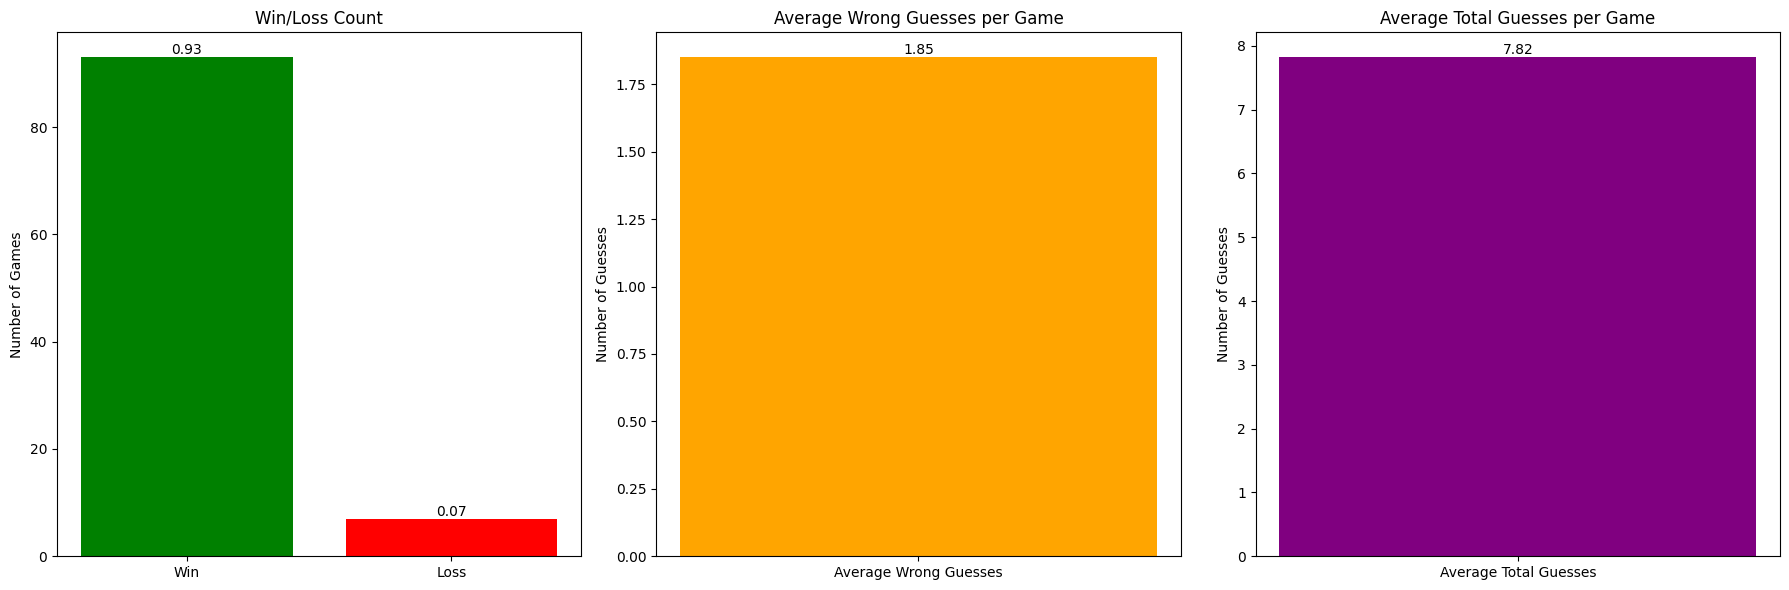

Quick evaluation - Win rate: 0.9300
Evaluating agent over 2000 games...
Completed 100/2000 games - Win rate: 0.9000, Avg Wrong Guesses: 2.2400
Completed 200/2000 games - Win rate: 0.9300, Avg Wrong Guesses: 2.0300
Completed 300/2000 games - Win rate: 0.9367, Avg Wrong Guesses: 1.9367
Completed 400/2000 games - Win rate: 0.9375, Avg Wrong Guesses: 1.8325
Completed 500/2000 games - Win rate: 0.9480, Avg Wrong Guesses: 1.7940
Completed 600/2000 games - Win rate: 0.9467, Avg Wrong Guesses: 1.7383
Completed 700/2000 games - Win rate: 0.9486, Avg Wrong Guesses: 1.7229
Completed 800/2000 games - Win rate: 0.9475, Avg Wrong Guesses: 1.7312
Completed 900/2000 games - Win rate: 0.9478, Avg Wrong Guesses: 1.7400
Completed 1000/2000 games - Win rate: 0.9500, Avg Wrong Guesses: 1.7400
Completed 1100/2000 games - Win rate: 0.9464, Avg Wrong Guesses: 1.7536
Completed 1200/2000 games - Win rate: 0.9450, Avg Wrong Guesses: 1.7542
Completed 1300/2000 games - Win rate: 0.9446, Avg Wrong Guesses: 1.7546
C

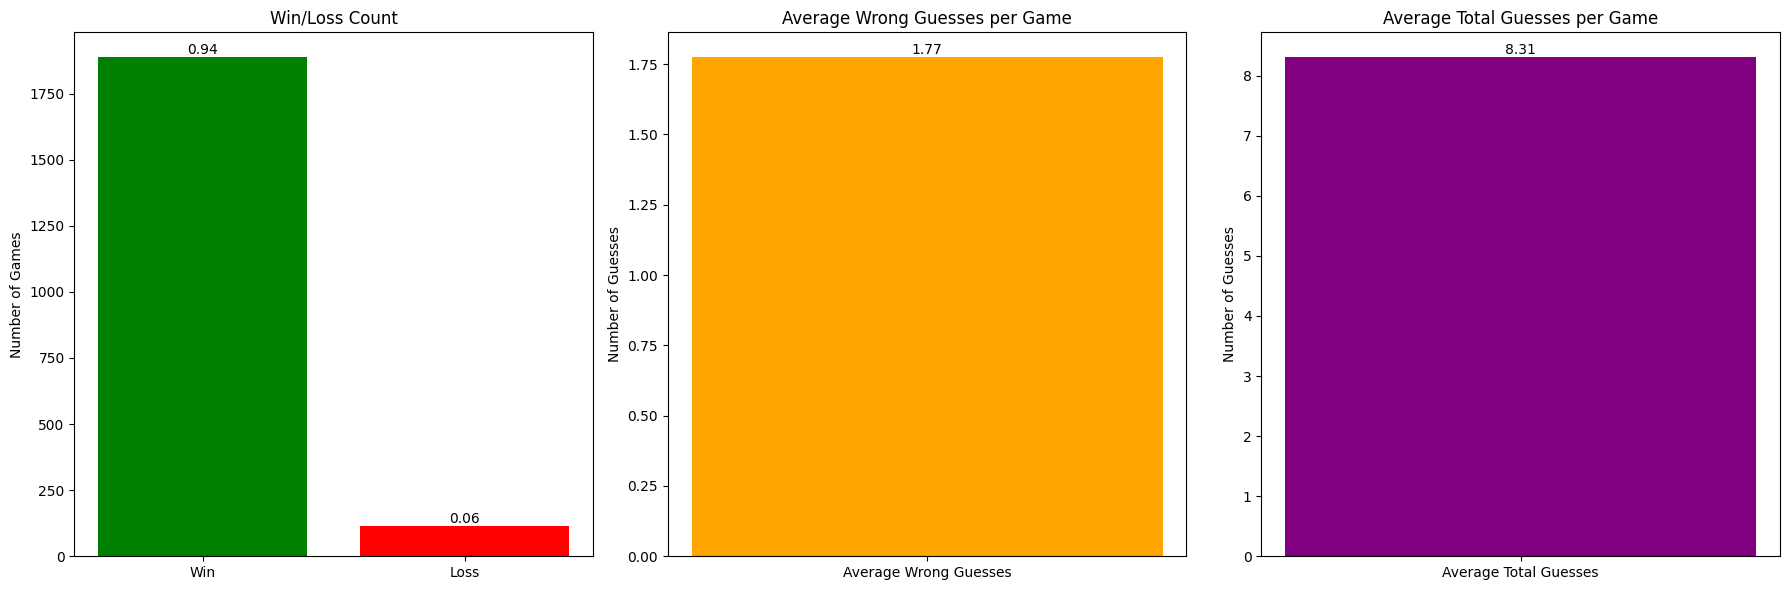

Model saved to hangman_model.pkl


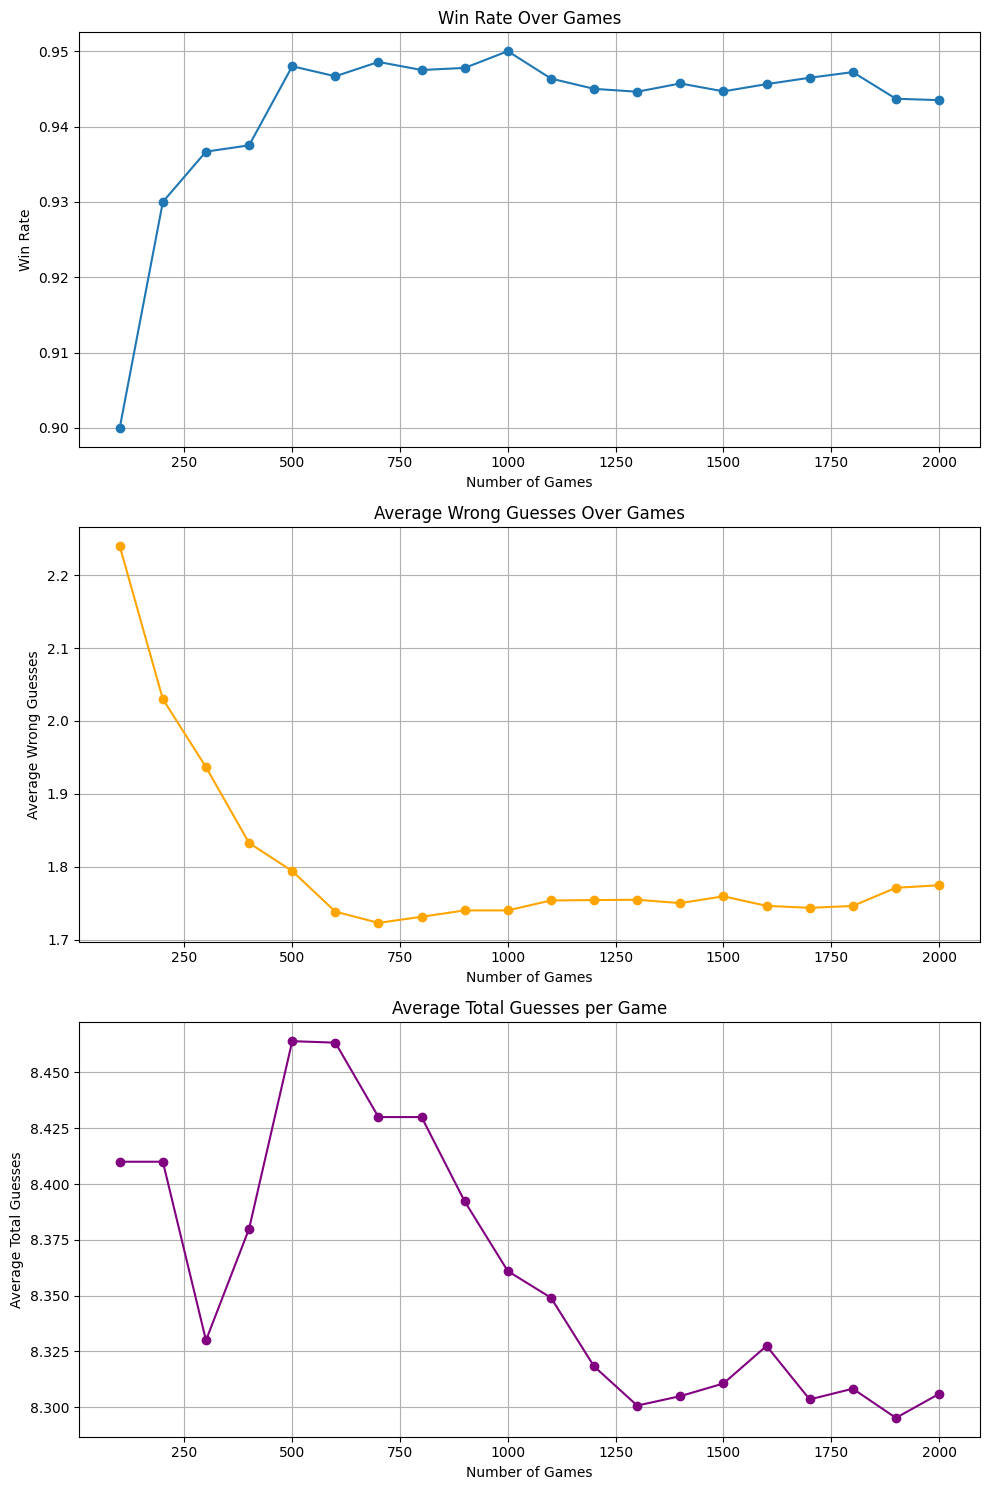

In [15]:
def main():
    """Main function to run the Hangman assistant"""
    print("Intelligent Hangman Assistant")
    print("="*50)

    # Initialize game with test.txt
    game = HangmanGame(corpus_file='test.txt')

    # Plot corpus analysis (only if needed)
    print("\nAnalyzing corpus...")
    # Comment out for faster TTI - uncomment if you want to see analysis
    # game.corpus_analyzer.plot_analysis()

    # Train models with optimized parameters
    print("\nTraining HMM models...")
    game.hmm_trainer.train_all_models(epochs=25)  # Reduced epochs for faster training

    # Evaluate agent with smaller initial evaluation
    print("\nTraining and evaluating RL agent...")
    # Quick evaluation first
    quick_eval = game.evaluate_agent(num_games=100, verbose=False)
    print(f"Quick evaluation - Win rate: {quick_eval['win_rate']:.4f}")

    # Full evaluation
    evaluation = game.evaluate_agent(num_games=2000, verbose=False)

    # Save models
    game.save_model()

    # Return evaluation for plotting
    return evaluation

# Run main and store the evaluation results
evaluation = main()

# Access the periodic metrics from the evaluation results
if 'evaluation' in locals() and evaluation and 'periodic_metrics' in evaluation:
    periodic_metrics = evaluation['periodic_metrics']

    game_intervals = periodic_metrics.get('game_intervals')
    win_rates = periodic_metrics.get('win_rates')
    avg_wrong_guesses = periodic_metrics.get('avg_wrong_guesses')
    avg_total_guesses = periodic_metrics.get('avg_total_guesses')

    if game_intervals and win_rates and avg_wrong_guesses and avg_total_guesses:
        # Create figure and subplots
        fig, axes = plt.subplots(3, 1, figsize=(10, 15))

        # Plot Win Rate
        axes[0].plot(game_intervals, win_rates, marker='o', linestyle='-')
        axes[0].set_title('Win Rate Over Games')
        axes[0].set_xlabel('Number of Games')
        axes[0].set_ylabel('Win Rate')
        axes[0].grid(True)

        # Plot Average Wrong Guesses
        axes[1].plot(game_intervals, avg_wrong_guesses, marker='o', linestyle='-', color='orange')
        axes[1].set_title('Average Wrong Guesses Over Games')
        axes[1].set_xlabel('Number of Games')
        axes[1].set_ylabel('Average Wrong Guesses')
        axes[1].grid(True)

        # Plot Average Total Guesses
        axes[2].plot(game_intervals, avg_total_guesses, marker='o', linestyle='-', color='purple')
        axes[2].set_title('Average Total Guesses per Game')
        axes[2].set_xlabel('Number of Games')
        axes[2].set_ylabel('Average Total Guesses')
        axes[2].grid(True)

        # Adjust layout and save figure
        plt.tight_layout()
        plt.savefig('training_progress.png', dpi=300, bbox_inches='tight')

        # Display the plots
        plt.show()
    else:
        print("Periodic metrics lists are incomplete.")
else:
    print("Evaluation results or periodic metrics not found after running main.")
